# Gaussian on a Grid Test with compositional score matching

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \mu \sim \mathcal{N}(0, 3^2),\qquad \log\tau \sim \mathcal{N}(0, 1^2)$$

- The local parameters are different for each grid point
$$ \theta_{i,j} \sim \mathcal{N}(\mu, \tau^2)$$

-  In each grid point, we have a Brownian motion with drift:
$$ dx_t = \theta \cdot dt + \sqrt{dt} \cdot dW_t$$
- We observe $T=10$ time points for each grid point over a time horizon of `max_time=1`.

In [ ]:
import os
import numpy as np

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from problems.gaussian_grid import Prior, Simulator, visualize_simulation_output, plot_shrinkage, get_stan_posterior

In [ ]:
n_grid = 4
T = 10
N = n_grid * n_grid  # number of samples
data_samples = 100

prior = Prior()
simulator = Simulator(n_time_points=T)

global_param_names = [r'$\mu$', r'$\log \tau$']
local_param_names = [f'theta[{i}]' for i in range(n_grid * n_grid)]

# test the simulator
sim_test = simulator(prior.sample_full(1, n_grid=n_grid))['observable']
visualize_simulation_output(sim_test)

In [ ]:
np.random.seed(0)

global_posteriors = []
local_posteriors = []

true_global = []
true_local = []

for i in range(data_samples):
    param_sample = prior.sample_full(1, n_grid=n_grid)
    true_global.append([param_sample['mu'][0, 0], param_sample['log_tau'][0, 0]])
    true_local.append(param_sample['theta'].flatten())
    sim_test = simulator(param_sample)['observable'][0]

    global_posterior, local_posterior = get_stan_posterior(sim_test, dt_obs=simulator.dt, verbose=False if i != 0 else True)
    global_posteriors.append(global_posterior)
    local_posteriors.append(local_posterior)

# make numpy arrays
global_posterior = np.stack(global_posteriors, axis=0)
local_posterior = np.stack(local_posteriors, axis=0).transpose(0, 2, 1)

true_global = np.stack(true_global, axis=0)
true_local = np.stack(true_local, axis=0)

In [ ]:
np.save('problems/grid/global_posterior.npy', global_posterior)
np.save('problems/grid/local_posterior.npy', local_posterior)
np.save('problems/grid/true_global.npy', true_global)
np.save('problems/grid/true_local.npy', true_local)

# Plotting

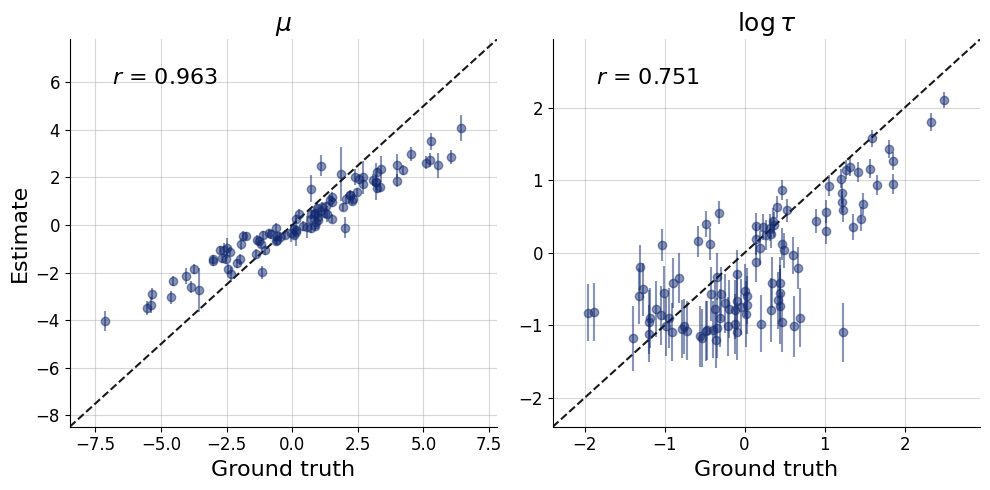

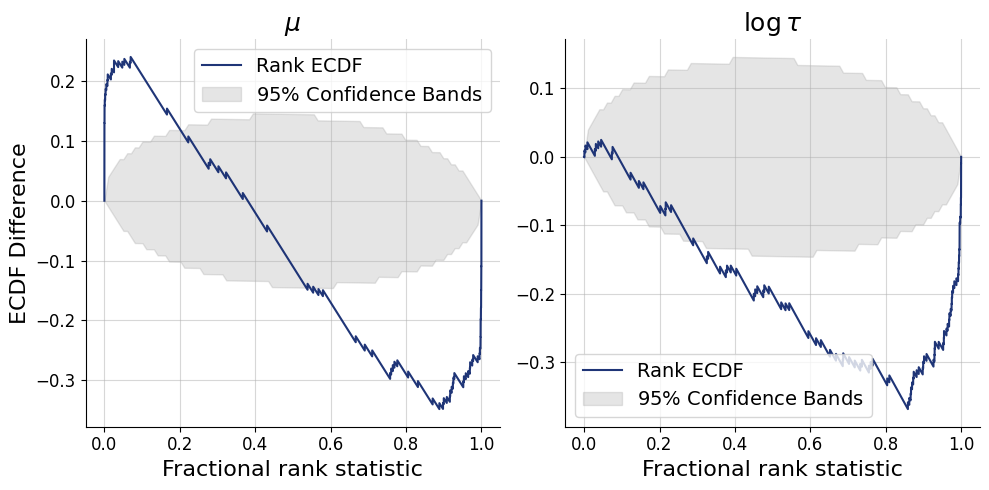

In [10]:
diagnostics.recovery(global_posterior, true_global, variable_names=global_param_names)
diagnostics.calibration_ecdf(global_posterior, true_global, difference=True, variable_names=global_param_names);

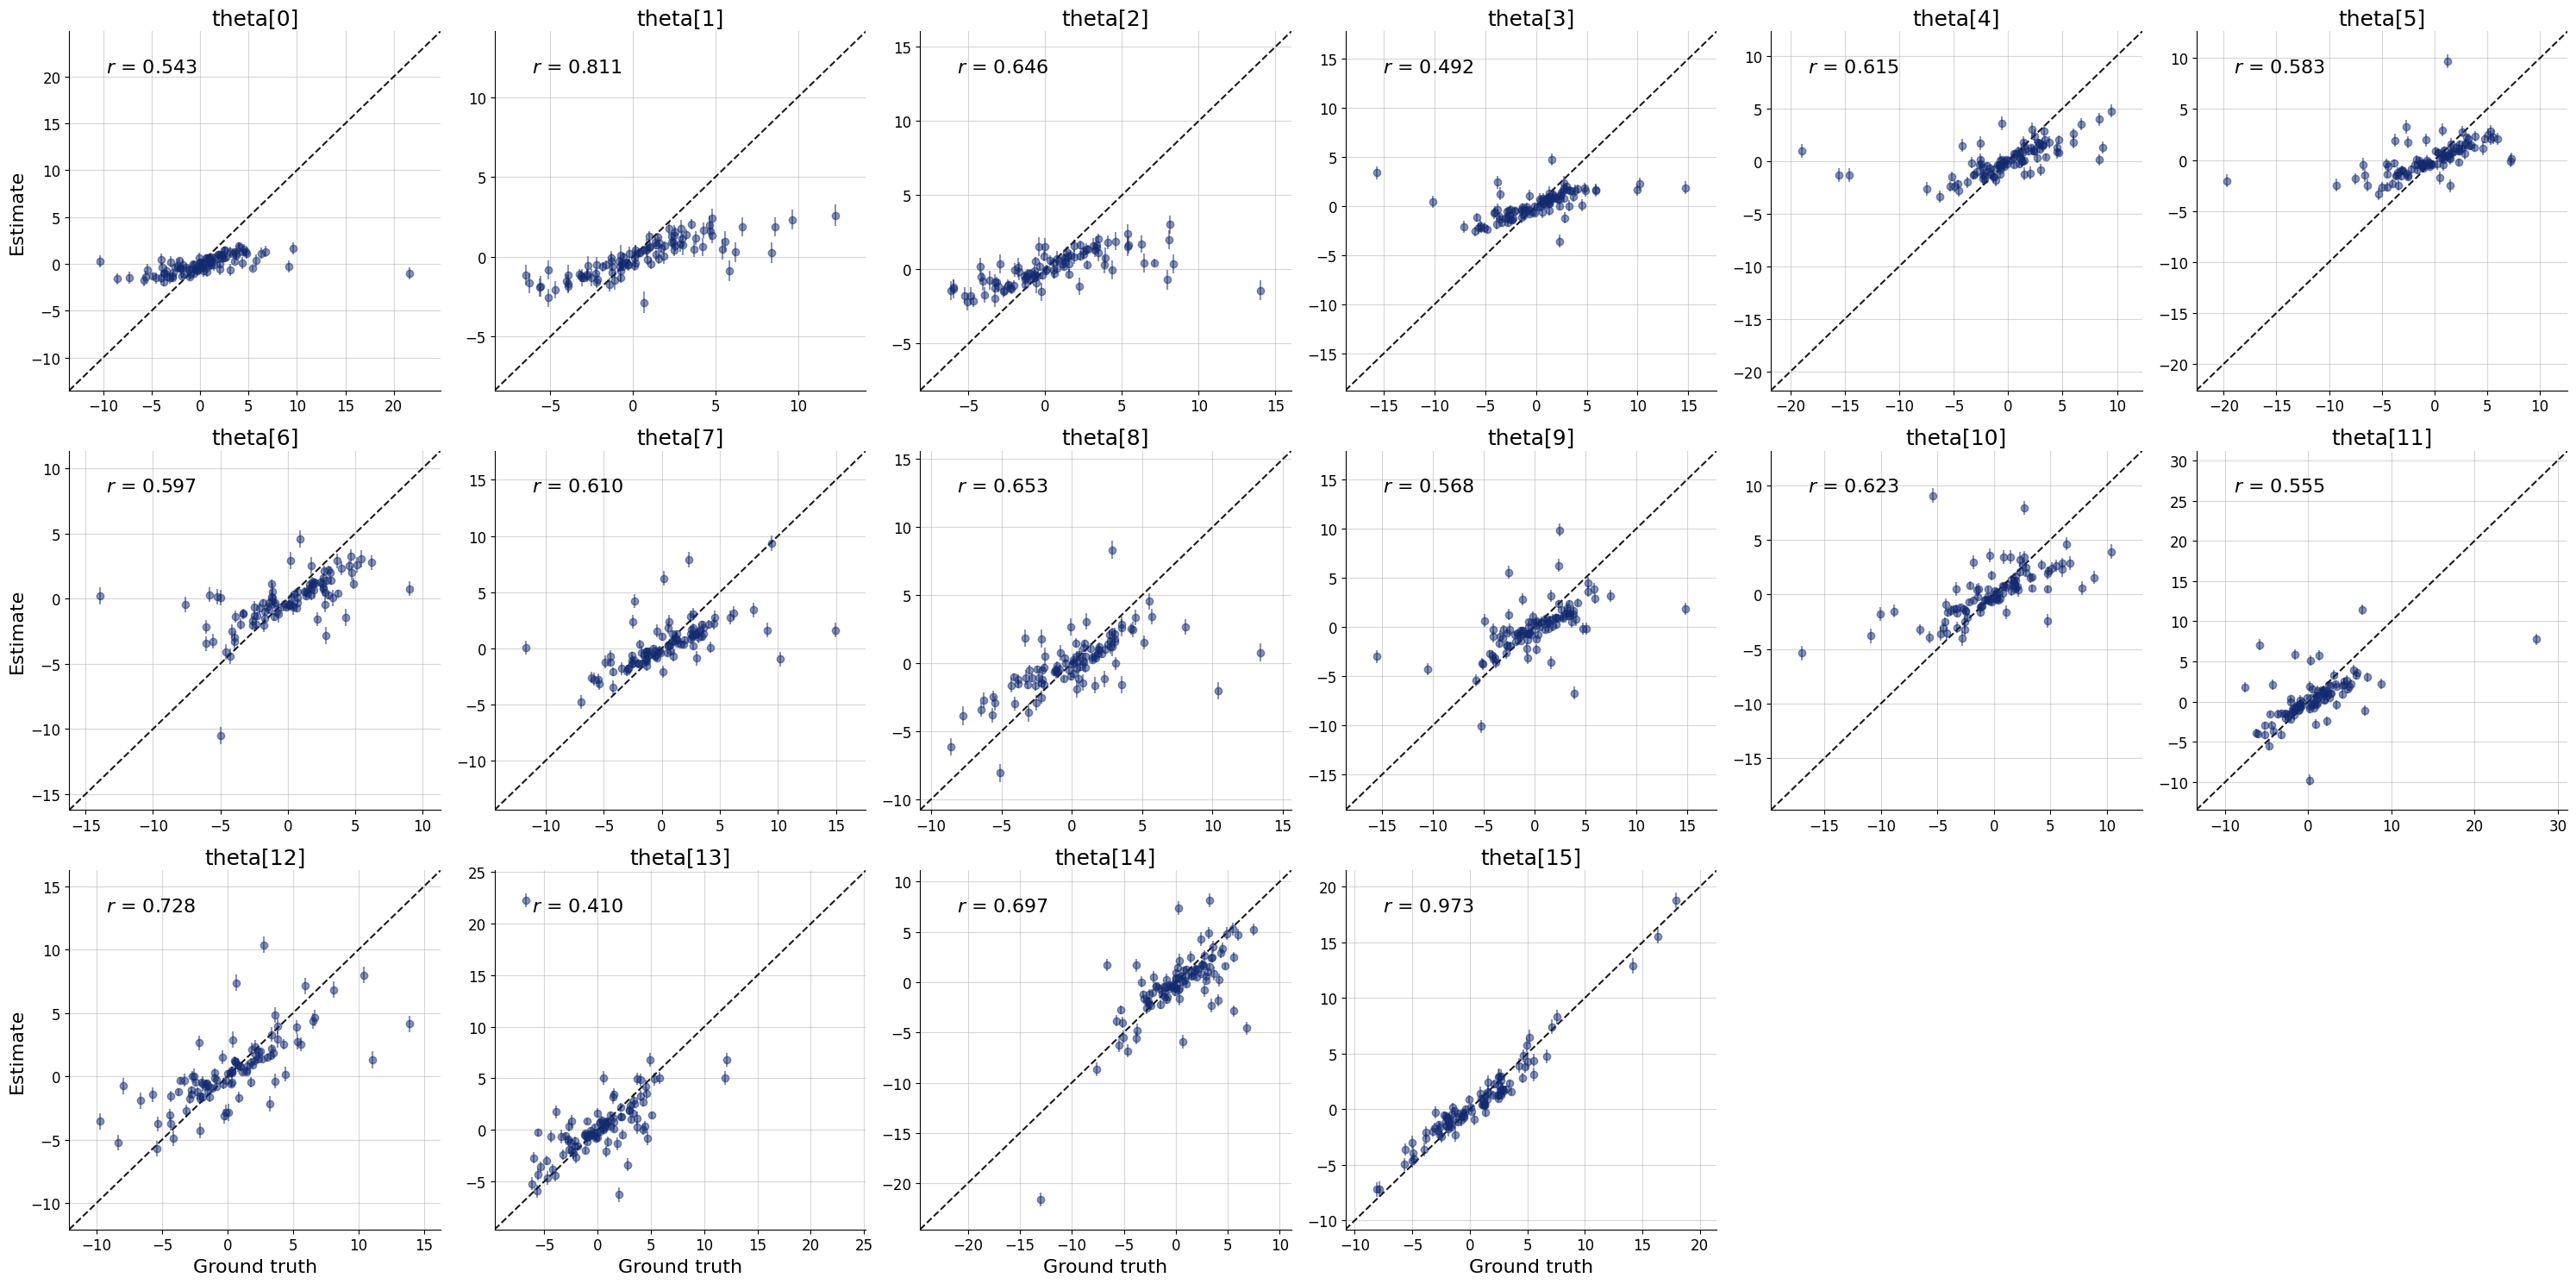

In [11]:
diagnostics.recovery(local_posterior, true_local, variable_names=local_param_names);

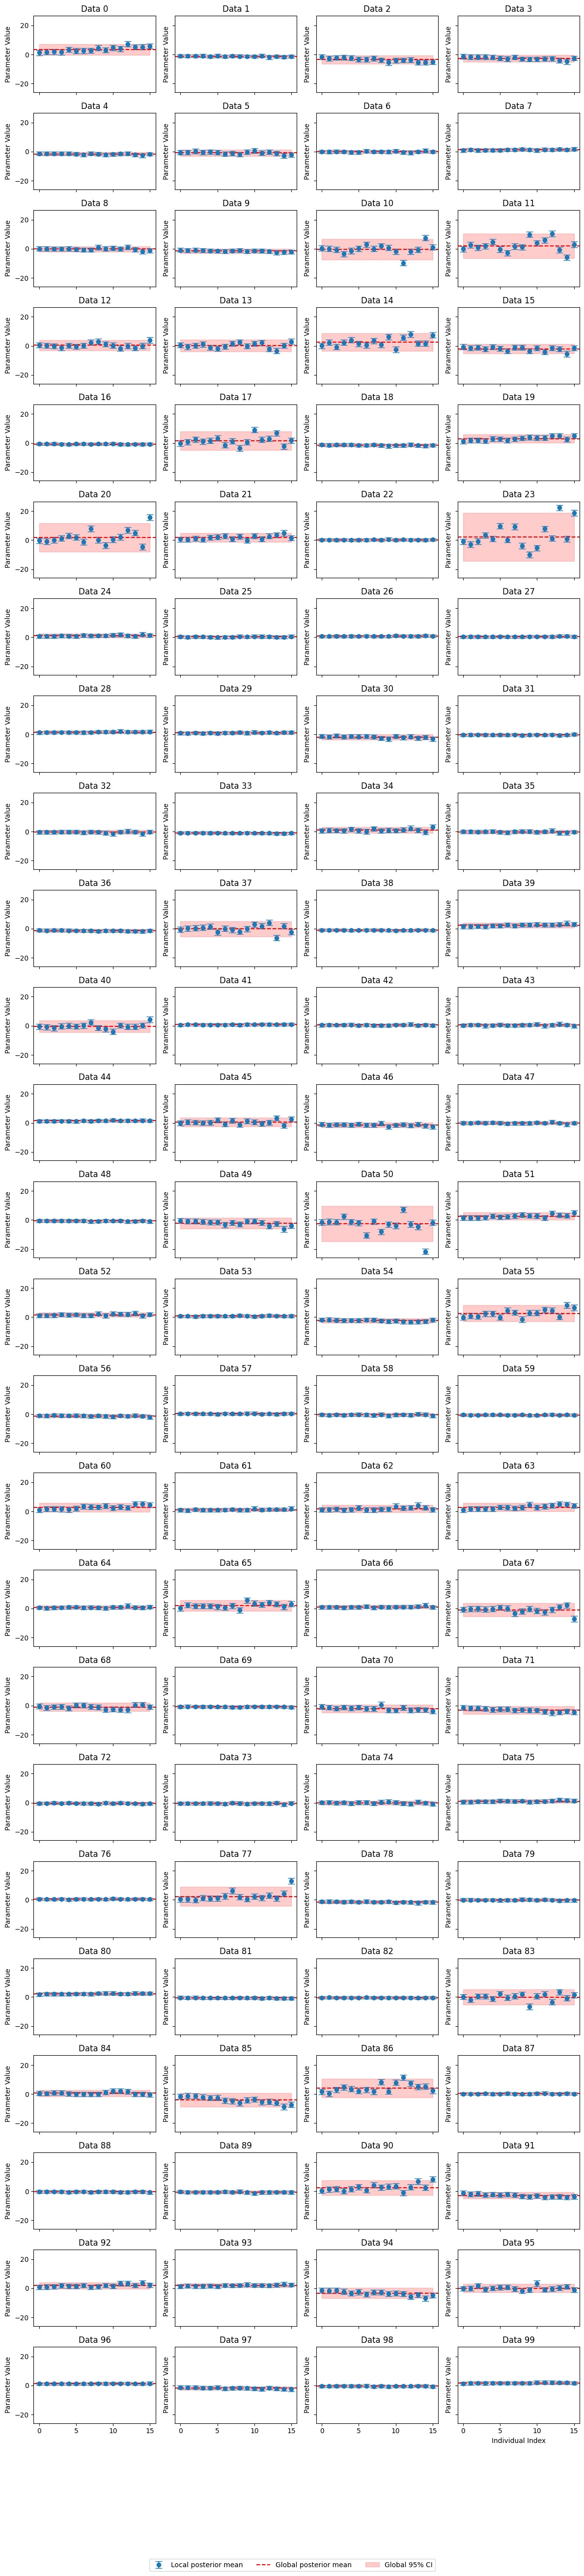

In [12]:
plot_shrinkage(global_posterior, local_posterior[:, :, :, np.newaxis])